**Classification using Pre-trained Networks**

In [0]:
# import Keras & Tensorflow
import tensorflow as tf
from tensorflow import keras

# Load pre-trained Resnet50
model = keras.applications.resnet50.ResNet50(weights="imagenet")

In [15]:
# Connect with Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
model.summary()

In [0]:
# Load in image and perform classification
import keras.preprocessing.image as image
img = image.load_img("/content/gdrive/My Drive/elephant.jpg", target_size=(224, 224)) # the image is in the root of Google Drive
# convert the image pixels to a numpy array
img = image.img_to_array(img)
# reshape data for the model
img = img.reshape((1, img.shape[0], img.shape[1], img.shape[2]))
# prepare the image for the model
img = keras.applications.resnet50.preprocess_input(img)
Y_prob = model.predict(img)
# Show top K prediction
top_K = keras.applications.resnet50.decode_predictions(Y_prob, top=3)
for class_id, name, y_proba in top_K[0]:
  print("class_id:", class_id, "name:", name, " ", y_proba*100, "%")



Using TensorFlow backend.


class_id: n02504458 name: African_elephant   88.72683644294739 %
class_id: n01871265 name: tusker   5.695364996790886 %
class_id: n02504013 name: Indian_elephant   4.0331341326236725 %


**Fine-tuning pre-trained models**

In [22]:
# We use Tensorflow provided tf_flowers dataset
# https://www.tensorflow.org/tutorials/load_data/images
import tensorflow_datasets as tfds
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
print("size: ", dataset_size)
class_names = info.features["label"].names
print("classes: ", class_names)
n_classes = info.features["label"].num_classes
print("num. classes: ", n_classes)

size:  3670
classes:  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
num. classes:  5


In [0]:
# Split data into training, test and validation
# Setting as_supervised to True to include ground truth labels
test_set = tfds.load("tf_flowers", split="train[:10%]", as_supervised=True)
valid_set = tfds.load("tf_flowers", split="train[10%:25%]", as_supervised=True)
train_set = tfds.load("tf_flowers", split="train[25%:]", as_supervised=True)

In [0]:
# Data preprocessing
def preprocess(image, label):
  resized_image = tf.image.resize(image, [224, 224])
  final_image = keras.applications.xception.preprocess_input(resized_image)
  return final_image, label

batch_size = 32
train_set = train_set.shuffle(1000)
train_set = train_set.map(preprocess).repeat().batch(batch_size).prefetch(1)
valid_set = valid_set.map(preprocess).repeat().batch(batch_size).prefetch(1)
test_set = test_set.map(preprocess).batch(batch_size).prefetch(1)

In [0]:
# Fine-tuning xception model
base_model = keras.applications.xception.Xception(weights="imagenet", include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.Model(inputs=base_model.input, outputs=output)
model.summary()

In [0]:
# Training with existing layers fixed
for layer in base_model.layers:
  layer.trainable = False
optimizer = keras.optimizers.SGD(lr=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, epochs=5, steps_per_epoch=dataset_size*0.75//batch_size, validation_data=valid_set, validation_steps = dataset_size*0.15//batch_size)


Train for 86.0 steps, validate for 17.0 steps
Epoch 1/5
86/86 [==============================] - 1069s 12s/step - loss: 0.6828 - accuracy: 0.7809 - val_loss: 1.6288 - val_accuracy: 0.6949
Epoch 2/5
86/86 [==============================] - 1055s 12s/step - loss: 0.3677 - accuracy: 0.8786 - val_loss: 1.1511 - val_accuracy: 0.7537
Epoch 3/5
86/86 [==============================] - 1056s 12s/step - loss: 0.2320 - accuracy: 0.9193 - val_loss: 1.0347 - val_accuracy: 0.7629
Epoch 4/5
86/86 [==============================] - 1058s 12s/step - loss: 0.1809 - accuracy: 0.9415 - val_loss: 1.2009 - val_accuracy: 0.7518
Epoch 5/5
52/86 [=================>............] - ETA: 6:07 - loss: 0.1810 - accuracy: 0.9417

In [0]:
# The model can be further trained with base layers unfrozen
for layer in base_model.layers:
  layer.trainable = True

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
history = model.fit(train_set, epochs=40, steps_per_epoch=dataset_size*0.75//batch_size, validation_data=valid_set, validation_steps = dataset_size*0.15//batch_size)


In [16]:
# Autoencoder example using fashion MNIST
# Load image data
fashion_mnist = keras.datasets.fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Data preparation:
#   Map intensities from [0--255] to 0.0--1.0
x_train = x_train / 255.0
x_test = x_test / 255.0
encoder = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[28, 28]),
  keras.layers.Dense(100, activation="selu"),
  keras.layers.Dense(30, activation="selu")
])
decoder = keras.models.Sequential([
  keras.layers.Dense(100, activation="selu", input_shape=[30]),
  keras.layers.Dense(28*28, activation="sigmoid"),
  keras.layers.Reshape([28, 28])
])
ae = keras.models.Sequential([encoder, decoder])
ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.5))
history=ae.fit(x_train, x_train, epochs=10, validation_split=0.1)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 10s 192us/sample - loss: 0.3384 - val_loss: 0.3127
Epoch 2/10
54000/54000 [==============================] - 9s 173us/sample - loss: 0.3058 - val_loss: 0.3056
Epoch 3/10
54000/54000 [==============================] - 9s 173us/sample - loss: 0.2994 - val_loss: 0.2991
Epoch 4/10
54000/54000 [==============================] - 9s 174us/sample - loss: 0.2955 - val_loss: 0.2971
Epoch 5/10
54000/54000 [==============================] - 9s 172us/sample - loss: 0.2928 - val_loss: 0.2974
Epoch 6/10
54000/54000 [==============================] - 9s 169us/sample - loss: 0.2908 - val_loss: 0.2952
Epoch 7/10
54000/54000 [==============================] - 9s 170us/sample - loss: 0.2893 - val_loss: 0.2911
Epoch 8/10
54000/54000 [==============================] - 9s 170us/sample - loss: 0.2882 - val_loss: 0.2895
Epoch 9/10
54000/54000 [==============================] - 9s 171us/sample - loss: 0.28

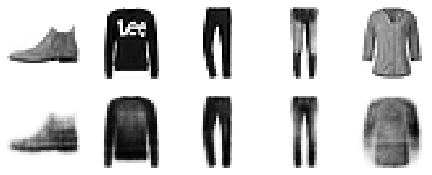

In [18]:
# Visualise results
import matplotlib.pyplot as plt
def plot_image(image):
  plt.imshow(image, cmap="binary")
  plt.axis("off")

n_images = 5
reconstructions = ae.predict(x_test[:n_images])
fig=plt.figure(figsize=(n_images*1.5, 3))
for idx in range(n_images):
  plt.subplot(2, n_images, 1+idx)
  plot_image(x_test[idx])
  plt.subplot(2, n_images, 1+n_images+idx)
  plot_image(reconstructions[idx])
  